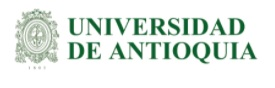
<h1> Sistema de recomendación - Banco Santander kaggle challenge - Monografía </h1>
<h3>Hector David Ardila Soto
<br><br>Universidad de Antioquia
<br>Facultad de Ingeniería </h3>


<Hr>

<p>Se importan las librerías necesarias para ejecutar el código</p>

In [404]:
import numpy as np
import pandas as pd
import dask
import dask.dataframe as dd
from functools import reduce
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score, plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, balanced_accuracy_score,precision_recall_curve
from collections import defaultdict
import xgboost as xgb

<h5>Se carga el dataset completo utilzando dask, luego obtenemos los meses deseados para realizar las recomendaciones</h5>

In [405]:
df_raw = dd.read_csv("train_ver2.csv",dtype={'ult_fec_cli_1t':str,'indrel':str,'age':str,'sexo':str,'antiguedad':str,'indrel_1mes':str,'conyuemp':str, 'ind_ahor_fin_ult1': float, 'ind_aval_fin_ult1': float, 'ind_cco_fin_ult1': float,
                                                       'ind_cder_fin_ult1': float, 'ind_cno_fin_ult1': float, 'ind_ctju_fin_ult1': float,
                                                       'ind_ctma_fin_ult1': float, 'ind_ctop_fin_ult1': float, 'ind_ctpp_fin_ult1': float,
                                                       'ind_deco_fin_ult1': float, 'ind_deme_fin_ult1': float, 'ind_dela_fin_ult1': float,
                                                       'ind_ecue_fin_ult1': float, 'ind_fond_fin_ult1': float, 'ind_hip_fin_ult1': float,
                                                       'ind_plan_fin_ult1': float, 'ind_pres_fin_ult1': float, 'ind_reca_fin_ult1': float,
                                                       'ind_tjcr_fin_ult1': float, 'ind_valo_fin_ult1': float, 'ind_viv_fin_ult1': float,
                                                       'ind_nomina_ult1': float, 'ind_nom_pens_ult1': float, 'ind_recibo_ult1': float})

<p>Las columnas <b>fecha_dato</b> y <b>fecha_alta</b> las pasamos a formato datetime </p>

In [406]:
df_raw['fecha_dato'] = dd.to_datetime(df_raw['fecha_dato'],format ='%y%m%d',errors='ignore')

In [407]:
df_raw['fecha_alta'] = dd.to_datetime(df_raw['fecha_alta'],format ='%y%m%d',errors='ignore')

In [408]:
df_raw.head()

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,2015-01-28,1375586,N,ES,H,35,2015-01-12,0.0,6,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2015-01-28,1050611,N,ES,V,23,2012-08-10,0.0,35,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2015-01-28,1050612,N,ES,V,23,2012-08-10,0.0,35,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2015-01-28,1050613,N,ES,H,22,2012-08-10,0.0,35,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2015-01-28,1050614,N,ES,V,23,2012-08-10,0.0,35,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<p>Se segmentan por meses y se almacenan en el lugar de almacenamiento del notebook</p>

In [409]:
#Nuevo grupos por meses
df_raw_copy = df_raw.copy()

In [410]:
#datos del mes 2015-06-28
mes_2015_10_28 =  df_raw_copy[df_raw_copy['fecha_dato'] == '2015-10-28']
mes_2015_10_28.to_csv('mes_2015_10_28_normal.csv',single_file = True)

['C:/Users/Hector Ardila/Desktop/Jupyter/Final Banco Santander/mes_2015_10_28_normal.csv']

In [411]:
#datos del mes 2015-07-28
mes_2015_11_28 =  df_raw_copy[df_raw_copy['fecha_dato'] == '2015-11-28']
mes_2015_11_28.to_csv('mes_2015_11_28_normal.csv',single_file = True)

['C:/Users/Hector Ardila/Desktop/Jupyter/Final Banco Santander/mes_2015_11_28_normal.csv']

In [412]:
#datos del mes 2015-02-28
mes_2015_12_28 =  df_raw_copy[df_raw_copy['fecha_dato'] == '2015-12-28']
mes_2015_12_28.to_csv('mes_2015_12_28_normal.csv',single_file = True)

['C:/Users/Hector Ardila/Desktop/Jupyter/Final Banco Santander/mes_2015_12_28_normal.csv']

In [413]:
#datos del mes 2015-02-28
mes_2016_03_28 =  df_raw_copy[df_raw_copy['fecha_dato'] == '2016-03-28']
mes_2016_03_28.to_csv('mes_2016_03_28_normal.csv',single_file = True)

['C:/Users/Hector Ardila/Desktop/Jupyter/Final Banco Santander/mes_2016_03_28_normal.csv']

In [414]:
#datos del mes 2015-02-28
mes_2016_04_28 =  df_raw_copy[df_raw_copy['fecha_dato'] == '2016-04-28']
mes_2016_04_28.to_csv('mes_2016_04_28_normal.csv',single_file = True)

['C:/Users/Hector Ardila/Desktop/Jupyter/Final Banco Santander/mes_2016_04_28_normal.csv']

In [415]:
#datos del mes 2015-02-28
mes_2016_05_28 =  df_raw_copy[df_raw_copy['fecha_dato'] == '2016-05-28']
mes_2016_05_28.to_csv('mes_2016_05_28_normal.csv',single_file = True)

['C:/Users/Hector Ardila/Desktop/Jupyter/Final Banco Santander/mes_2016_05_28_normal.csv']

<p> Se cargan los meses deseados y se eliminan el archivo de dask para liberar espacio de memoria</p>

In [416]:
del df_raw
del df_raw_copy
del mes_2015_10_28 , mes_2015_11_28, mes_2015_12_28,mes_2016_03_28, mes_2016_04_28, mes_2016_05_28 

In [417]:
#meses a importar 
#'2015-10-28', '2015-11-28', '2015-12-28','2016-03-28', '2016-04-28', '2016-05-28', '2016-06-28',
data_frames_normal = list()

moths_address = {'df_mes_10_1':'mes_2015_10_28_normal.csv','df_mes_11_1':'mes_2015_11_28_normal.csv',
                 'df_mes_12_1':'mes_2015_12_28_normal.csv','df_mes_13_1':'mes_2016_03_28_normal.csv',
                 'df_mes_14_1':'mes_2016_04_28_normal.csv','df_mes_16_1':'mes_2016_05_28_normal.csv',
                 'df_mes_18_1':'test_ver2.csv',}
for month,address in moths_address.items():
    data_frames_normal.append(pd.read_csv(address, dtype={'ult_fec_cli_1t':str,'indrel':str,'age':str,'sexo':str,'antiguedad':str,'indrel_1mes':str,'conyuemp':str, 'ind_ahor_fin_ult1': int, 'ind_aval_fin_ult1': int, 'ind_cco_fin_ult1': int,
                                                       'ind_cder_fin_ult1': int, 'ind_cno_fin_ult1': int, 'ind_ctju_fin_ult1': int,
                                                       'ind_ctma_fin_ult1': int, 'ind_ctop_fin_ult1': int, 'ind_ctpp_fin_ult1': int,
                                                       'ind_deco_fin_ult1': int, 'ind_deme_fin_ult1': int, 'ind_dela_fin_ult1': int,
                                                       'ind_ecue_fin_ult1': int, 'ind_fond_fin_ult1': int, 'ind_hip_fin_ult1': int,
                                                       'ind_plan_fin_ult1': int, 'ind_pres_fin_ult1': int, 'ind_reca_fin_ult1': int,
                                                       'ind_tjcr_fin_ult1': int, 'ind_valo_fin_ult1': int, 'ind_viv_fin_ult1': int,
                                                       'ind_nomina_ult1': int, 'ind_nom_pens_ult1': int, 'ind_recibo_ult1': int}))
    
    

<p>Ejecución de prueba para corroborar la carga de los datos</p>

In [418]:
data_frames_normal[5]['nomprov']

0            MADRID
1            MADRID
2         RIOJA, LA
3           BIZKAIA
4         BARCELONA
            ...    
931448     ZARAGOZA
931449    RIOJA, LA
931450     ZARAGOZA
931451     ZARAGOZA
931452       MADRID
Name: nomprov, Length: 931453, dtype: object

<p>Se crea una lista con los productos presentes en el dataset, se utilizará e partes del código</p>

In [419]:
products = ['ind_ahor_fin_ult1','ind_aval_fin_ult1','ind_cco_fin_ult1','ind_cder_fin_ult1','ind_cno_fin_ult1','ind_ctju_fin_ult1',
               'ind_ctma_fin_ult1','ind_ctop_fin_ult1','ind_ctpp_fin_ult1','ind_deco_fin_ult1','ind_deme_fin_ult1','ind_dela_fin_ult1',
               'ind_ecue_fin_ult1','ind_fond_fin_ult1','ind_hip_fin_ult1','ind_plan_fin_ult1','ind_pres_fin_ult1','ind_reca_fin_ult1',
               'ind_tjcr_fin_ult1','ind_valo_fin_ult1','ind_viv_fin_ult1','ind_nomina_ult1','ind_nom_pens_ult1','ind_recibo_ult1']

<p>Se convierten en valores númericos las características antiguedad, age, indrel, renta, ind_nuevo</p>

In [420]:
for i  in range(0,len(data_frames_normal)):  
    data_frames_normal[i].antiguedad = pd.to_numeric(data_frames_normal[i].antiguedad,errors="coerce")
    data_frames_normal[i].age  = pd.to_numeric(data_frames_normal[i].age, errors="coerce")
    data_frames_normal[i].indrel  = pd.to_numeric(data_frames_normal[i].indrel, errors="coerce")
    data_frames_normal[i].renta  = pd.to_numeric(data_frames_normal[i].renta, errors="coerce")
    data_frames_normal[i].ind_nuevo = pd.to_numeric(data_frames_normal[i].ind_nuevo,errors="coerce")

<p>Se obtiene una vista previa de los datos, observa valores nulos</p>

In [421]:
#datos nulos
data_frames_normal[0].isnull().any()

Unnamed: 0               False
fecha_dato               False
ncodpers                 False
ind_empleado             False
pais_residencia          False
sexo                      True
age                      False
fecha_alta               False
ind_nuevo                False
antiguedad               False
indrel                   False
ult_fec_cli_1t            True
indrel_1mes               True
tiprel_1mes               True
indresi                  False
indext                   False
conyuemp                  True
canal_entrada             True
indfall                  False
tipodom                  False
cod_prov                  True
nomprov                   True
ind_actividad_cliente    False
renta                     True
segmento                  True
ind_ahor_fin_ult1        False
ind_aval_fin_ult1        False
ind_cco_fin_ult1         False
ind_cder_fin_ult1        False
ind_cno_fin_ult1         False
ind_ctju_fin_ult1        False
ind_ctma_fin_ult1        False
ind_ctop

<hr>

<h4>Limpieza de datos</h4>

<p>En la característica edad se encontraron, datos atípicos. Se procede a enviarlos al centro de la distribución</p>

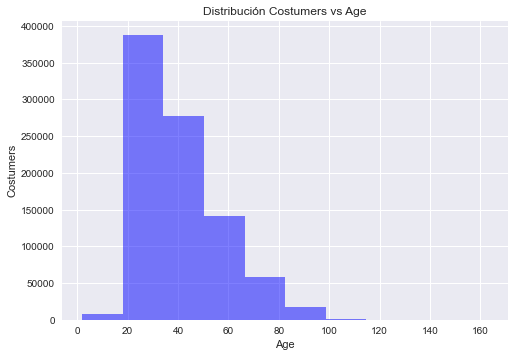

In [422]:
x = data_frames_normal[0]["age"]
n,bins, patches = plt.hist(x,10,facecolor='blue', alpha=0.5)

plt.xlabel('Age')
plt.ylabel('Costumers')
plt.title(r'Distribución Costumers vs Age')

plt.savefig('Costumers_vs_age.jpg', bbox_inches='tight')

In [423]:
def fillage(df_users_age):
    filter_under_18 = df_users_age['age']<=18
    filter_over_100 = df_users_age['age']>=100
    #Se le asigna valor medio de los datos mas cercanos
    closest_under_18 = df_users_age.loc[(df_users_age['age']>=18) & (df_users_age['age']<=40),"age"].mean(skipna=True)
    closest_over_100 = df_users_age.loc[(df_users_age['age'] >= 40) & (df_users_age['age']<= 100),"age"].mean(skipna=True)
    df_users_age.loc[filter_under_18, 'age'] = closest_under_18
    df_users_age.loc[filter_over_100, 'age'] = closest_over_100
    df_users_age["age"].fillna(df_users_age["age"].median(),inplace=True)
    df_users_age["age"]                  = df_users_age["age"].astype(int)
    

<p>Correción por meses de este característica</p>

In [424]:
for i  in range(0,len(data_frames_normal)):   
    fillage(data_frames_normal[i])

<p>Vizualización luego del ajuste de datos</p>

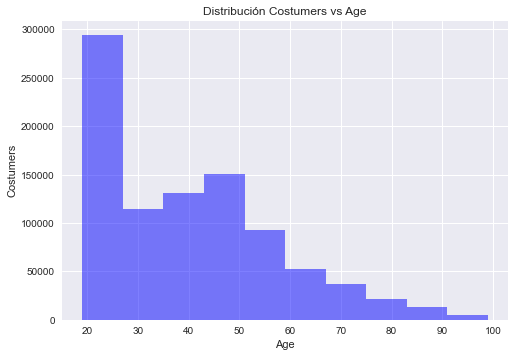

In [425]:
x = data_frames_normal[2]["age"]
n,bins, patches = plt.hist(x,10,facecolor='blue', alpha=0.5)

plt.xlabel('Age')
plt.ylabel('Costumers')
plt.title(r'Distribución Costumers vs Age')

plt.savefig('Costumers_vs_age.jpg', bbox_inches='tight')

<p>Se buscan datos nulos en las características ind_nuevo, antiguedad, fecha_Alta, para esto de cargan solo esas caracteristicas</p>

In [426]:
#Second  cleaning the data by antiguedad
df_users_fecha_alta = pd.read_csv("train_ver2.csv",usecols=['fecha_dato', 'ncodpers', 'ind_nuevo','fecha_alta','antiguedad'])
print(df_users_fecha_alta.shape)
df_users_fecha_alta.head()

C:\Users\Hector Ardila\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(13647309, 5)


,fecha_dato,ncodpers,fecha_alta,ind_nuevo,antiguedad
0,2015-01-28,1375586,2015-01-12,0.0,6
1,2015-01-28,1050611,2012-08-10,0.0,35
2,2015-01-28,1050612,2012-08-10,0.0,35
3,2015-01-28,1050613,2012-08-10,0.0,35
4,2015-01-28,1050614,2012-08-10,0.0,35


In [427]:
df_users_fecha_alta['antiguedad'] = pd.to_numeric(df_users_fecha_alta['antiguedad'],errors="coerce")
df_users_fecha_alta['ind_nuevo'] = pd.to_numeric(df_users_fecha_alta['ind_nuevo'],errors="coerce")

In [428]:
#ind_nuevo shows that a user whether is new costumer in a year or not.
months_active = df_users_fecha_alta.loc[df_users_fecha_alta["ind_nuevo"].isnull(),:]
months_active_1 = df_users_fecha_alta.loc[df_users_fecha_alta["antiguedad"].isnull(),:]
months_active_2 = df_users_fecha_alta.loc[df_users_fecha_alta["fecha_alta"].isnull(),:]
print(f"{months_active['fecha_dato'].value_counts()}")
print(f"{months_active_1['fecha_dato'].value_counts()}")
print(f"{months_active_2['fecha_dato'].value_counts()}")

2015-01-28    6953
2015-02-28    5940
2015-03-28    5091
2015-04-28    4292
2015-05-28    3597
2015-06-28    1861
Name: fecha_dato, dtype: int64
2015-01-28    6953
2015-02-28    5940
2015-03-28    5091
2015-04-28    4292
2015-05-28    3597
2015-06-28    1861
Name: fecha_dato, dtype: int64
2015-01-28    6953
2015-02-28    5940
2015-03-28    5091
2015-04-28    4292
2015-05-28    3597
2015-06-28    1861
Name: fecha_dato, dtype: int64


In [429]:
del df_users_fecha_alta

<p>Los valores nulos en estas características van disminuyendo con el pasar de los meses, los valores nulos restantes aparecen en el mes 6, por esto, se tomarán como nuevos usuarios.</p>

In [430]:
for i  in range(0,len(data_frames_normal)):
    ind_nuevo_null = data_frames_normal[i]['ind_nuevo'].isnull()
    data_frames_normal[i].loc[ind_nuevo_null, 'ind_nuevo']=1
data_frames_normal[1].isnull().any()

Unnamed: 0               False
fecha_dato               False
ncodpers                 False
ind_empleado             False
pais_residencia          False
sexo                      True
age                      False
fecha_alta               False
ind_nuevo                False
antiguedad               False
indrel                   False
ult_fec_cli_1t            True
indrel_1mes               True
tiprel_1mes               True
indresi                  False
indext                   False
conyuemp                  True
canal_entrada             True
indfall                  False
tipodom                   True
cod_prov                  True
nomprov                   True
ind_actividad_cliente    False
renta                     True
segmento                  True
ind_ahor_fin_ult1        False
ind_aval_fin_ult1        False
ind_cco_fin_ult1         False
ind_cder_fin_ult1        False
ind_cno_fin_ult1         False
ind_ctju_fin_ult1        False
ind_ctma_fin_ult1        False
ind_ctop

<p>Los valores nulos en antiguedad son los mismos que en ind_nuevo, por lo cual, la antiguedad asignada a datos nulos será cero, además, se coloca el condicional de agregar cero si se encuentras valores menores a cero en antiguedad.</p>

In [431]:
for i  in range(0,len(data_frames_normal)):
    filter_outliers = data_frames_normal[i].antiguedad<0
    filter_null = data_frames_normal[i].antiguedad.isnull() 
    data_frames_normal[i].loc[filter_outliers,'antiguedad']=0
    data_frames_normal[i].loc[filter_null,'antiguedad']=0
data_frames_normal[1].isnull().any()

Unnamed: 0               False
fecha_dato               False
ncodpers                 False
ind_empleado             False
pais_residencia          False
sexo                      True
age                      False
fecha_alta               False
ind_nuevo                False
antiguedad               False
indrel                   False
ult_fec_cli_1t            True
indrel_1mes               True
tiprel_1mes               True
indresi                  False
indext                   False
conyuemp                  True
canal_entrada             True
indfall                  False
tipodom                   True
cod_prov                  True
nomprov                   True
ind_actividad_cliente    False
renta                     True
segmento                  True
ind_ahor_fin_ult1        False
ind_aval_fin_ult1        False
ind_cco_fin_ult1         False
ind_cder_fin_ult1        False
ind_cno_fin_ult1         False
ind_ctju_fin_ult1        False
ind_ctma_fin_ult1        False
ind_ctop

<p>A la característica indrel se le asigna 1 por defecto al ser el valor más común. Igualmente a la característica ind_actividad_cliente se le adiciona cero por ser lo mas común</p>

In [432]:
print('indrel conteo de datos')
print(data_frames_normal[0].indrel.value_counts())

indrel conteo de datos
1     890239
99      2012
Name: indrel, dtype: int64


In [433]:
for i  in range(0,len(data_frames_normal)):
    data_frames_normal[i].loc[data_frames_normal[i].indrel.isnull(), 'indrel']=1

In [434]:
for i  in range(0,len(data_frames_normal)):
    data_frames_normal[i].loc[data_frames_normal[i]['ind_actividad_cliente'].isnull(),'ind_actividad_cliente']=0

<p>A la característica nomprov se le adiciona un valor temporal 'Default' el cual se cambia por Madrid, los datos relacionados con 'Default' tienen una media de ingresos casí como la media de ingresos en madrid.</p>

In [435]:
for i  in range(0,len(data_frames_normal)):
    data_frames_normal[i].loc[data_frames_normal[i].nomprov.isnull(),"nomprov"] = "Default"

<p>Aunque esta característica no se utilizará en el entrenamiento del modelo,se le adiciona un valor unos días anteriores a fecha_dato</p>

In [436]:
##fecha alta tend to be a date before fecha_dato, the NAN value will be fill in this way
for i  in range(0,len(data_frames_normal)):
    data_frames_normal[i].loc[((data_frames_normal[i].fecha_dato=='2015-01-28') & (data_frames_normal[i].fecha_alta.isnull())),'fecha_alta']='2015-01-25'

    
    data_frames_normal[i].loc[((data_frames_normal[i].fecha_dato=='2015-02-28') & (data_frames_normal[i].fecha_alta.isnull())),'fecha_alta']='2015-02-25'

   
    data_frames_normal[i].loc[((data_frames_normal[i].fecha_dato=='2015-03-28') & (data_frames_normal[i].fecha_alta.isnull())),'fecha_alta']='2015-03-25'

    
    data_frames_normal[i].loc[((data_frames_normal[i].fecha_dato=='2015-04-28') & (data_frames_normal[i].fecha_alta.isnull())),'fecha_alta']='2015-04-25'

    
    data_frames_normal[i].loc[((data_frames_normal[i].fecha_dato=='2015-05-28') & (data_frames_normal[i].fecha_alta.isnull())),'fecha_alta']='2015-05-25'

    
    data_frames_normal[i].loc[((data_frames_normal[i].fecha_dato=='2015-06-28') & (data_frames_normal[i].fecha_alta.isnull())),'fecha_alta']='2015-06-25'

data_frames_normal[2].isnull().any()

Unnamed: 0               False
fecha_dato               False
ncodpers                 False
ind_empleado             False
pais_residencia          False
sexo                      True
age                      False
fecha_alta               False
ind_nuevo                False
antiguedad               False
indrel                   False
ult_fec_cli_1t            True
indrel_1mes               True
tiprel_1mes               True
indresi                  False
indext                   False
conyuemp                  True
canal_entrada             True
indfall                  False
tipodom                  False
cod_prov                  True
nomprov                  False
ind_actividad_cliente    False
renta                     True
segmento                  True
ind_ahor_fin_ult1        False
ind_aval_fin_ult1        False
ind_cco_fin_ult1         False
ind_cder_fin_ult1        False
ind_cno_fin_ult1         False
ind_ctju_fin_ult1        False
ind_ctma_fin_ult1        False
ind_ctop

<p>Los valores promedio de la característica income se obtuvieron previamente</p>

In [437]:

media_income_dict = \
{'ALAVA'                   :   96967.65,
'ALBACETE'                 :  78657.30,
'ALICANTE'                 :  67526.28,
'ALMERIA'                  :  73390.65,
'ASTURIAS'                 :  87199.38,
'AVILA'                     : 68561.28,
'BADAJOZ'                  :  62330.97,
'BALEARS, ILLES'          :  123573.51,
'BARCELONA'               :  131214.48,
'BIZKAIA'                 :   99978.78,
'BURGOS'                   :  89385.09,
'CACERES'                  :  67799.49,
'CADIZ'                  :    79016.37,
'CANTABRIA'               :   95517.60,
'CASTELLON'               :   66630.30,
'CEUTA'                  :   128699.58,
'CIUDAD REAL'            :    62193.45,
'CORDOBA'               :     69106.89,
'CORUÑA, A'               :   97689.30,
'CUENCA'                  :   67201.41,
'GIPUZKOA'                :   80599.14,
'GIRONA'                  :  108963.21,
'GRANADA'                 :   82447.02,
'GUADALAJARA'             :   92724.66,
'HUELVA'                  :   68994.30,
'HUESCA'                  :   73467.81,
'JAEN'                    :   67886.40,
'LEON'                    :   80901.54,
'LERIDA'                :     64818.45,
'LUGO'                      : 64390.53,
'MADRID'                   : 139070.97,
'MALAGA'                    : 95102.61,
'MELILLA'                   :117408.66,
'MURCIA'                    : 67813.86,
'NAVARRA'                   : 86649.27,
'OURENSE'                   : 79069.62,
'PALENCIA'                   :86593.08,
'PALMAS, LAS'                :80948.61,
'PONTEVEDRA'                 :97829.10,
'RIOJA, LA'                  :89936.28,
'SALAMANCA'                  :89831.25,
'SANTA CRUZ DE TENERIFE'     :82729.23,
'SEGOVIA'                    :89311.56,
'SEVILLA'                    :92710.35,
'SORIA'                      :78810.90,
'TARRAGONA'                  :88283.46,
'TERUEL'                     :76467.57,
'TOLEDO'                     :68867.76,
'Default'                   :137860.11,
'VALENCIA'                  : 72988.98,
'VALLADOLID'                : 92880.39,
'ZAMORA'                    : 74692.71,
'ZARAGOZA'                  : 99950.28}
for i in range(0, len(data_frames_normal)):
      for prov,incom in media_income_dict.items():
                data_frames_normal[i].loc[((data_frames_normal[i]['nomprov']==prov) & (data_frames_normal[i]['renta'].isnull())), 'renta'] = incom


<p>Se grafíca el top 23 de ingresos por nomprov</p>

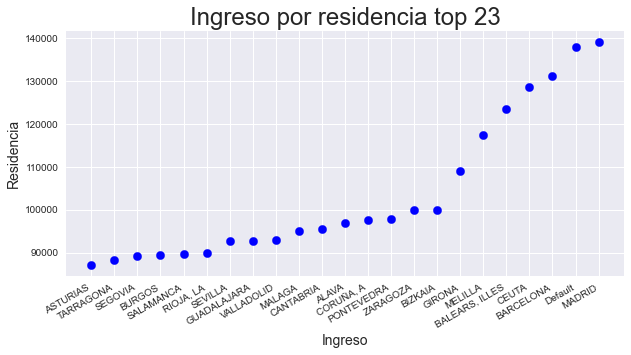

In [494]:
import pandas as pd
import numpy as np
x=[]
y=[]
media_income_dict = {prov: income for prov, income in sorted(media_income_dict.items(), key=lambda item: item[1])}
for prov,income in media_income_dict.items():
    x.append(prov), y.append(income)
import matplotlib.pyplot as plt

plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(10, 5))
fig.autofmt_xdate()
ax.set_title('Ingreso por residencia top 23', fontsize=24)
ax.set_xlabel('Ingreso', fontsize = 14)
ax.set_ylabel('Residencia', fontsize = 14)
ax.scatter(x[30:],y[30:],c='blue', s=70)

<p>Observando la gráfica se decide asignar MADRID a los datos nulos en la característica nomprov</p> 

In [439]:
for i in range(0, len(data_frames_normal)):
    data_frames_normal[i].loc[data_frames_normal[i]['nomprov']=='Default', 'nomprov']='MADRID'

<p>Solamente los productos ind_nomina_ult1, ind_nom_pens_ult1 presentan valores nulos, se decide adicionar cero en estos valores nulos, cero es el valor más común </p>

In [440]:
for i in range(0, len(data_frames_normal[:6])):
    data_frames_normal[i].loc[data_frames_normal[i].ind_nomina_ult1.isnull(), "ind_nomina_ult1"] = 0
    data_frames_normal[i].loc[data_frames_normal[i].ind_nom_pens_ult1.isnull(), "ind_nom_pens_ult1"] = 0

<p> A las siguientes características se les adiciona el valor más común : tiprel_1mes, indfall, sexo, canal_entrada </p>

In [441]:
for i in range(0, len(data_frames_normal)):
    data_frames_normal[i]["indfall"] = data_frames_normal[i]["indfall"].fillna("N")
    data_frames_normal[i]["tiprel_1mes"] = data_frames_normal[i]["tiprel_1mes"].fillna("A")

In [442]:
for i in range(0, len(data_frames_normal)):
    data_frames_normal[i]['sexo'] = data_frames_normal[i]["sexo"].fillna("V")

In [443]:
for i in range(0, len(data_frames_normal)):
    data_frames_normal[i]['canal_entrada'] = data_frames_normal[i]["canal_entrada"].fillna("KHE")

In [444]:
for i in range(0, len(data_frames_normal)):
    data_frames_normal[i]['segmento'] = data_frames_normal[i]["segmento"].fillna("02 - PARTICULARES")    

In [445]:
for i in range(0, len(data_frames_normal)):
    data_frames_normal[i]['pais_residencia'] = data_frames_normal[i]["pais_residencia"].fillna("ES")    

<p> A las siguientes características se les adiciona un valor por defecto(Default), estas no seran utilizadas para realizar las recomendaciones : ult_fec_cli_1t, conyuemp</p>

In [446]:
for i in range(0, len(data_frames_normal)):
    string_data = data_frames_normal[i].select_dtypes(include=["object"])
    missing_columns = [col for col in string_data if string_data[col].isnull().any()]
    unknown_cols = [col for col in missing_columns if col not in ["indfall","tiprel_1mes","indrel_1mes"]]
    for col in unknown_cols:
        data_frames_normal[i].loc[data_frames_normal[i][col].isnull(),col] = "Default"
        print(unknown_cols)

['ult_fec_cli_1t', 'conyuemp']
['ult_fec_cli_1t', 'conyuemp']
['ult_fec_cli_1t', 'conyuemp']
['ult_fec_cli_1t', 'conyuemp']
['ult_fec_cli_1t', 'conyuemp']
['ult_fec_cli_1t', 'conyuemp']
['ult_fec_cli_1t', 'conyuemp']
['ult_fec_cli_1t', 'conyuemp']
['ult_fec_cli_1t', 'conyuemp']
['ult_fec_cli_1t', 'conyuemp']
['ult_fec_cli_1t', 'conyuemp']
['ult_fec_cli_1t', 'conyuemp']
['ult_fec_cli_1t', 'conyuemp']
['ult_fec_cli_1t', 'conyuemp']


<h3>Codificación</h3>
<p>Se crean dictionarios para realizar la codificación en ciertas características</p>

In [447]:
##Create a Dictinary
ind_empleado_dict = {
    'N':0,
    'A':1,
    'F':2,
    'B':3,
    'S':4  
}

sexo_dict = {
    'V':0,
    'H':1
}


indrel_1mes_dict = {
    '1.0':1, 
    '1':1, 
    '2.0':2, 
    '2':2,
    '3.0':3, 
    '3':3, 
    '4.0':4, 
    '4':4,
    'P':5
}


tiprel_1mes_dict = {
     'A':0, 
     'I':1,
     'P':2,
     'R':3, 
     'N':4
}

indresi_dict = {
     'N':0,
     'S':1
}


indext_dict = {
     'N':0, 
     'S':1
}


indfall_dict = {
     'N':0,
     'S':1
}



segmento_dict = {
    '02 - PARTICULARES':0,
    '03 - UNIVERSITARIO':1,
    '01 - TOP':2,
}     

canal_entrada_dict ={
 'KHE': 0,
 'KAT': 1,
 'KFC': 2,
 'KHQ': 3,
 'KFA': 4,
 'KHK': 5,
 'KHM': 6,
 'KHD': 7,
 'KHN': 8,
 'KAS': 9,
 'RED': 10,
 'KAG': 11,
 'KAY': 12,
 'KAA': 13,
 'KAB': 14,
 'KAE': 15,
 'KCC': 16,
 'KBZ': 17,
 'KHL': 18,
 'KFD': 19,
 'KAI': 20,
 'KEY': 21,
 'KAW': 22,
 'KAR': 23,
 'KAZ': 24,
 'KAF': 25,
 '007': 26,
 '013': 27,
 'KCI': 28,
 'KAH': 29,
 'KAJ': 30,
 'KCH': 31,
 'KHF': 32,
 'KAQ': 33,
 'KHC': 34,
 'KAP': 35,
 'KAM': 36,
 'KAD': 37,
 'KFP': 38,
 'KGX': 39,
 'KEJ': 40,
 'KHO': 41,
 'KGV': 42,
 'KDR': 43,
 'KFT': 44,
 'KAC': 45,
 'KAL': 46,
 'KBO': 47,
 'KBH': 48,
 'KFG': 49,
 'KFS': 50,
 'KAO': 51,
 'KFJ': 52,
 'KES': 53,
 'KEW': 54,
 'KFF': 55,
 'KCG': 56,
 'KCB': 57,
 'KEN': 58,
 'KFU': 59,
 'KFN': 60,
 'KCL': 61,
 'KBQ': 62,
 'KGY': 63,
 'KFK': 64,
 'KFL': 65,
 'KBF': 66,
 'KCD': 67,
 'KCM': 68,
 'KBU': 69,
 'KED': 70,
 'KDU': 71,
 'KFH': 72,
 'KEL': 73,
 'KDM': 74,
 'KEZ': 75,
 'KDY': 76,
 'KDS': 77,
 'KEG': 78,
 'KBR': 79,
 'KDO': 80,
 'KDX': 81,
 'KBG': 82,
 'KEH': 83,
 'KDC': 84,
 'KCA': 85,
 'KAN': 86,
 'KDT': 87,
 'KBB': 88,
 'KBW': 89,
 'KCN': 90,
 'KDQ': 91,
 'KCU': 92,
 'KDP': 93,
 'KGW': 94,
 'KCK': 95,
 'KEI': 96,
 'KBV': 97,
 'KFI': 98,
 'KEA': 99,
 'KEO': 100,
 'KEV': 101,
 'KAK': 102,
 'KDE': 103,
 'KDW': 104,
 'KDF': 105,
 'KBS': 106,
 'KHP': 107,
 'KBY': 108,
 'KBL': 109,
 'KBM': 110,
 'KEK': 111,
 'KDD': 112,
 'KDZ': 113,
 'KBJ': 114,
 'KDG': 115,
 'KDV': 116,
 'KCF': 117,
 'KDA': 118,
 'KFM': 119,
 'KFR': 120,
 'KEB': 121,
 'KEF': 122,
 'KCE': 123,
 'KEU': 124,
 'KFE': 125,
 'KAU': 126,
 'KBD': 127,
 'KCS': 128,
 'KEC': 129,
 'KCV': 130,
 'KCJ': 131,
 '004': 132,
 'KCQ': 133,
 'KDN': 134,
 'KCR': 135,
 'KDH': 136,
 'KCO': 137,
 'KEE': 138,
 'KCP': 139,
 'K00': 140,
 'KBE': 141,
 'KEQ': 142,
 'KFB': 143,
 'KAV': 144,
 'KCT': 145,
 'KBX': 146,
 'KBP': 147,
 'KEM': 148,
 'KFV': 149,
 'KCX': 150,
 'KBN': 151,
 'KHA': 152,
 'KGU': 153,
 'KGC': 154,
 'KGN': 155,
 'KDB': 156,
 'KDI': 157,
 'KDL': 158,
 '025': 159,
 'KHS': 160,
 'KHR': 161}

nomprov_dict ={
 'MADRID':1,
 'BARCELONA':3,
 'VALENCIA':4,
 'SEVILLA':5,
 'CORUÑA, A':6,
 'MURCIA':7,
 'MALAGA':8,
 'ZARAGOZA':9,
 'ALICANTE':10,
 'CADIZ':11,
 'PONTEVEDRA':12,
 'ASTURIAS':13,
 'VALLADOLID':14,
 'PALMAS, LAS':15,
 'BADAJOZ':16,
 'BIZKAIA':17,
 'TOLEDO':18,
 'GRANADA':19,
 'SALAMANCA':20,
 'CANTABRIA':21,
 'CORDOBA':22,
 'CACERES':23,
 'BALEARS, ILLES':24,
 'HUELVA':25,
 'CIUDAD REAL':26,
 'ALBACETE':27,
 'CASTELLON':28,
 'TARRAGONA':29,
 'BURGOS':30,
 'GIRONA':31,
 'NAVARRA':32,
 'RIOJA, LA':33,
 'LUGO':34,
 'OURENSE':35,
 'LEON':36,
 'LERIDA':37,
 'GIPUZKOA':38,
 'SANTA CRUZ DE TENERIFE':39,
 'GUADALAJARA':40,
 'JAEN':41,
 'ALMERIA':42,
 'CUENCA':43,
 'ZAMORA':44,
 'PALENCIA':45,
 'SEGOVIA':46,
 'HUESCA':47,
 'AVILA':48,
 'ALAVA':49,
 'TERUEL':50,
 'SORIA':51,
 'MELILLA':52,
 'CEUTA':53
}

pais_residencia_dict = {
'ES': 0,
 'FR': 1,
 'AR': 2,
 'DE': 3,
 'GB': 4,
 'US': 5,
 'CO': 6,
 'IT': 7,
 'RO': 8,
 'MX': 9,
 'BR': 10,
 'VE': 11,
 'EC': 12,
 'CH': 13,
 'BE': 14,
 'BO': 15,
 'PY': 16,
 'PT': 17,
 'CL': 18,
 'PE': 19,
 'RU': 20,
 'CU': 21,
 'NL': 22,
 'SE': 23,
 'PL': 24,
 'CN': 25,
 'UY': 26,
 'UA': 27,
 'AT': 28,
 'BG': 29,
 'CA': 30,
 'AU': 31,
 'DO': 32,
 'IL': 33,
 'IE': 34,
 'MA': 35,
 'FI': 36,
 'HN': 37,
 'GR': 38,
 'JP': 39,
 'DK': 40,
 'AE': 41,
 'NG': 42,
 'IN': 43,
 'CR': 44,
 'NO': 45,
 'GT': 46,
 'LU': 47,
 'GQ': 48,
 'ZA': 49,
 'SG': 50,
 'AD': 51,
 'BY': 52,
 'CZ': 53,
 'TH': 54,
 'SV': 55,
 'PR': 56,
 'KR': 57,
 'MD': 58,
 'DZ': 59,
 'SK': 60,
 'PK': 61,
 'CM': 62,
 'SA': 63,
 'PA': 64,
 'KE': 65,
 'HR': 66,
 'SN': 67,
 'EG': 68,
 'AO': 69,
 'TR': 70,
 'NI': 71,
 'QA': 72,
 'CI': 73,
 'GN': 74,
 'HK': 75,
 'MR': 76,
 'NZ': 77,
 'GA': 78,
 'MK': 79,
 'EE': 80,
 'LT': 81,
 'HU': 82,
 'ET': 83,
 'GW': 84,
 'MZ': 85,
 'BA': 86,
 'TW': 87,
 'VN': 88,
 'RS': 89,
 'PH': 90,
 'CG': 91,
 'OM': 92,
 'KW': 93,
 'MM': 94,
 'SL': 95,
 'CD': 96,
 'KZ': 97,
 'AL': 98,
 'TN': 99,
 'LY': 100,
 'TG': 101,
 'LB': 102,
 'GM': 103,
 'GI': 104,
 'BZ': 105,
 'IS': 106,
 'LV': 107,
 'KH': 108,
 'CF': 109,
 'GE': 110,
 'ML': 111,
 'GH': 112,
 'ZW': 113,
 'DJ': 114,
 'JM': 115,
 'BM': 116,
 'MT': 117}



<P>Se copia los dataframes para hacer el cambio de variables categóricas a numéricas </P>

In [448]:
data_frames_labeled = [] 
for data in data_frames_normal:
    data_frames_labeled.append(data.copy())

<hr>

<p>Se realiza la codificación</p>

In [449]:
for i in range(0, len(data_frames_labeled)):
    data_frames_labeled[i]['ind_empleado'] = data_frames_labeled[i].ind_empleado.map(ind_empleado_dict)
    data_frames_labeled[i]['sexo'] = data_frames_labeled[i].sexo.map(sexo_dict)
    data_frames_labeled[i]['pais_residencia'] = data_frames_labeled[i].pais_residencia.map(pais_residencia_dict)
    data_frames_labeled[i]['tiprel_1mes'] = data_frames_labeled[i].tiprel_1mes.map(tiprel_1mes_dict)
    data_frames_labeled[i]['indresi'] = data_frames_labeled[i].indresi.map(indresi_dict)
    data_frames_labeled[i]['indext'] = data_frames_labeled[i].indext.map(indext_dict)
    data_frames_labeled[i]['indfall'] = data_frames_labeled[i].indfall.map(indfall_dict)
    data_frames_labeled[i]['nomprov'] = data_frames_labeled[i].nomprov.map(nomprov_dict)
    data_frames_labeled[i]['segmento'] = data_frames_labeled[i].segmento.map(segmento_dict)
    data_frames_labeled[i]['indrel_1mes'] = data_frames_labeled[i].indrel_1mes.map(indrel_1mes_dict)
    data_frames_labeled[i]['canal_entrada'] = data_frames_labeled[i].canal_entrada.map(canal_entrada_dict)

<p>Se realiza una busqueda de datos nulos para corroborar que en este punto del dataset no se poseen.</p>

In [450]:
data_frames_labeled[3].isnull().any()

Unnamed: 0               False
fecha_dato               False
ncodpers                 False
ind_empleado             False
pais_residencia          False
sexo                     False
age                      False
fecha_alta               False
ind_nuevo                False
antiguedad               False
indrel                   False
ult_fec_cli_1t           False
indrel_1mes               True
tiprel_1mes              False
indresi                  False
indext                   False
conyuemp                 False
canal_entrada            False
indfall                  False
tipodom                  False
cod_prov                  True
nomprov                  False
ind_actividad_cliente    False
renta                    False
segmento                 False
ind_ahor_fin_ult1        False
ind_aval_fin_ult1        False
ind_cco_fin_ult1         False
ind_cder_fin_ult1        False
ind_cno_fin_ult1         False
ind_ctju_fin_ult1        False
ind_ctma_fin_ult1        False
ind_ctop

<p>Ahora se realiza la codificación One Hot a ciertas caracteriscas:</p>
<il>sexo, indresi, indext, indrel</il>

In [451]:
for i in range(0,len(data_frames_labeled)):
    data_frames_labeled[i] = pd.get_dummies(data_frames_labeled[i], columns=['sexo', 'indresi', 'indext','indrel'])

In [452]:
 data_frames_labeled[0].columns

Index(['Unnamed: 0', 'fecha_dato', 'ncodpers', 'ind_empleado',
       'pais_residencia', 'age', 'fecha_alta', 'ind_nuevo', 'antiguedad',
       'ult_fec_cli_1t', 'indrel_1mes', 'tiprel_1mes', 'conyuemp',
       'canal_entrada', 'indfall', 'tipodom', 'cod_prov', 'nomprov',
       'ind_actividad_cliente', 'renta', 'segmento', 'ind_ahor_fin_ult1',
       'ind_aval_fin_ult1', 'ind_cco_fin_ult1', 'ind_cder_fin_ult1',
       'ind_cno_fin_ult1', 'ind_ctju_fin_ult1', 'ind_ctma_fin_ult1',
       'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1', 'ind_deco_fin_ult1',
       'ind_deme_fin_ult1', 'ind_dela_fin_ult1', 'ind_ecue_fin_ult1',
       'ind_fond_fin_ult1', 'ind_hip_fin_ult1', 'ind_plan_fin_ult1',
       'ind_pres_fin_ult1', 'ind_reca_fin_ult1', 'ind_tjcr_fin_ult1',
       'ind_valo_fin_ult1', 'ind_viv_fin_ult1', 'ind_nomina_ult1',
       'ind_nom_pens_ult1', 'ind_recibo_ult1', 'sexo_0', 'sexo_1', 'indresi_0',
       'indresi_1', 'indext_0', 'indext_1', 'indrel_1', 'indrel_99'],
      dtype='object

<hr>  

<h3>productos</h3>
<p>Se crea una lista llamada columns_to_merge la cual solo selecciona ciertas características relacionadas en su mayoría con productos, las cuales se convierten en nuevas características para los meses de entrenamiento y validación, aportan al modelo comportamiento de los productos.</p>

In [453]:
columns_to_merge = ['ncodpers','ind_actividad_cliente','tiprel_1mes','indrel_1mes',
       'ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1',
       'ind_cder_fin_ult1', 'ind_cno_fin_ult1', 'ind_ctju_fin_ult1',
       'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1',
       'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1',
       'ind_ecue_fin_ult1', 'ind_fond_fin_ult1', 'ind_hip_fin_ult1',
       'ind_plan_fin_ult1', 'ind_pres_fin_ult1', 'ind_reca_fin_ult1',
       'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1',
       'ind_nomina_ult1', 'ind_nom_pens_ult1', 'ind_recibo_ult1',
        'indrel_1', 'indrel_99']

<p>Se crean dataset con columns_to_merge</p>

In [454]:
df_mes_0_to_merge = data_frames_labeled[0][columns_to_merge]
df_mes_1_to_merge = data_frames_labeled[1][columns_to_merge]
df_mes_2_to_merge = data_frames_labeled[2][columns_to_merge]
df_mes_3_to_merge = data_frames_labeled[3][columns_to_merge]
df_mes_4_to_merge = data_frames_labeled[4][columns_to_merge]
df_mes_5_to_merge = data_frames_labeled[5][columns_to_merge]

df_mes_5_to_merge.head()

,ncodpers,ind_actividad_cliente,tiprel_1mes,indrel_1mes,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,...,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1,indrel_1,indrel_99
0,657640,0.0,1,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,657788,1.0,0,1.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,657795,1.0,0,1.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,657790,1.0,0,1.0,0,0,0,0,1,0,...,0,0,1,0,0,1,1,1,1,0
4,657794,1.0,0,1.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


<p>Se suma el total de productos en los nuevos datasets creados y se crea una nueva característica</p>

In [455]:
df_mes_0_to_merge.loc[:,'cnt_mes0']=df_mes_0_to_merge.iloc[:,4:28].sum(axis=1)
df_mes_1_to_merge.loc[:,'cnt_mes1']=df_mes_1_to_merge.iloc[:,4:28].sum(axis=1)
df_mes_2_to_merge.loc[:,'cnt_mes2']=df_mes_2_to_merge.iloc[:,4:28].sum(axis=1)
df_mes_3_to_merge.loc[:,'cnt_mes3']=df_mes_3_to_merge.iloc[:,4:28].sum(axis=1)
df_mes_4_to_merge.loc[:,'cnt_mes4']=df_mes_4_to_merge.iloc[:,4:28].sum(axis=1)
df_mes_5_to_merge.loc[:,'cnt_mes5']=df_mes_5_to_merge.iloc[:,4:28].sum(axis=1)


df_mes_5_to_merge['cnt_mes5']

C:\Users\Hector Ardila\Anaconda\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Hector Ardila\Anaconda\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


0         0
1         1
2         1
3         6
4         2
         ..
931448    1
931449    1
931450    1
931451    1
931452    2
Name: cnt_mes5, Length: 931453, dtype: int64

<hr>

<h3>Se crean los conjuntos de entramiento y validación.</h3>

<h5>Entrenamiento</h5>
<p>Se toman del mes 2015-12-28 las características demográficas</p>   

In [456]:
mes_reference_to_train = data_frames_labeled[2].copy()
mes_reference_to_train = mes_reference_to_train.drop(columns=products, axis=1)

mes_reference_to_train 

,Unnamed: 0,fecha_dato,ncodpers,ind_empleado,pais_residencia,age,fecha_alta,ind_nuevo,antiguedad,ult_fec_cli_1t,...,renta,segmento,sexo_0,sexo_1,indresi_0,indresi_1,indext_0,indext_1,indrel_1,indrel_99
0,115651,2015-12-28,1017818,0,0,37,2012-05-29,0.0,43,Default,...,21214.02,0,1,0,0,1,1,0,1,0
1,115652,2015-12-28,1017819,0,0,51,2012-05-29,0.0,43,Default,...,108963.21,0,1,0,0,1,0,1,1,0
2,115653,2015-12-28,1017820,0,0,47,2012-05-29,0.0,43,Default,...,49255.80,0,1,0,0,1,1,0,1,0
3,115654,2015-12-28,1017821,0,0,54,2012-05-29,0.0,43,Default,...,195703.89,0,0,1,0,1,1,0,1,0
4,115655,2015-12-28,1017823,0,0,40,2012-05-29,0.0,43,Default,...,235765.74,0,1,0,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
912016,269100,2015-12-28,1400559,0,0,33,2015-06-05,1.0,5,Default,...,66072.24,1,1,0,0,1,1,0,1,0
912017,269101,2015-12-28,1400560,0,0,49,2015-06-05,0.0,6,2015-12-28,...,135082.77,0,0,1,0,1,1,0,0,1
912018,269102,2015-12-28,1400546,0,0,38,2015-06-05,0.0,6,Default,...,139070.97,0,1,0,0,1,0,1,1,0
912019,269103,2015-12-28,1400544,0,0,36,2015-06-05,0.0,6,Default,...,99144.57,0,1,0,0,1,1,0,1,0


<p>Se realiza un merge para adicionar al mes 2015-12-28 características relacionadas en su mayoría con productos de dos meses anteriores. Las que se obtuvieron con la lista columns_to_merge, en los pasos anteriores</p>

In [457]:
data_lags = [mes_reference_to_train,df_mes_1_to_merge,df_mes_0_to_merge]
mes_to_train_with_lag = reduce(lambda left,right: pd.merge(left,right,on='ncodpers',how='left'), data_lags)
# mes_to_train_with_lag_lag1 = mes_to_train_with_lag_lag1.fillna(0)
mes_to_train_with_lag.shape

(912021, 89)

In [458]:
mes_to_train_with_lag = mes_to_train_with_lag.fillna(0)
mes_to_train_with_lag

,Unnamed: 0,fecha_dato,ncodpers,ind_empleado,pais_residencia,age,fecha_alta,ind_nuevo,antiguedad,ult_fec_cli_1t,...,ind_reca_fin_ult1_y,ind_tjcr_fin_ult1_y,ind_valo_fin_ult1_y,ind_viv_fin_ult1_y,ind_nomina_ult1_y,ind_nom_pens_ult1_y,ind_recibo_ult1_y,indrel_1,indrel_99,cnt_mes0
0,115651,2015-12-28,1017818,0,0,37,2012-05-29,0.0,43,Default,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,115652,2015-12-28,1017819,0,0,51,2012-05-29,0.0,43,Default,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,115653,2015-12-28,1017820,0,0,47,2012-05-29,0.0,43,Default,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0
3,115654,2015-12-28,1017821,0,0,54,2012-05-29,0.0,43,Default,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0
4,115655,2015-12-28,1017823,0,0,40,2012-05-29,0.0,43,Default,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
912016,269100,2015-12-28,1400559,0,0,33,2015-06-05,1.0,5,Default,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0
912017,269101,2015-12-28,1400560,0,0,49,2015-06-05,0.0,6,2015-12-28,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
912018,269102,2015-12-28,1400546,0,0,38,2015-06-05,0.0,6,Default,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
912019,269103,2015-12-28,1400544,0,0,36,2015-06-05,0.0,6,Default,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0


<p>Ahora se crean más características, esta vez relacionas a que si el producto se mantuvo(0), se retiró(1) o se adicionó(-1) con relación a las características adicionadas de los dos meses anteriores. Estas características poseen el nombre del producto junto con la palabra 'estado' al final. Acá solo se realiza un comparación por productos entre dos meses</p>

In [459]:
for product in products:
    col_name = col_name = product+'estado'
    product_col = [col for col in mes_to_train_with_lag.columns if product in col]
    mes_to_train_with_lag[col_name] = mes_to_train_with_lag[product_col[0]]-mes_to_train_with_lag[product_col[1]]
    mes_to_train_with_lag.loc[mes_to_train_with_lag[col_name].isna(),col_name].fillna(0)
mes_to_train_with_lag.head()

,Unnamed: 0,fecha_dato,ncodpers,ind_empleado,pais_residencia,age,fecha_alta,ind_nuevo,antiguedad,ult_fec_cli_1t,...,ind_hip_fin_ult1estado,ind_plan_fin_ult1estado,ind_pres_fin_ult1estado,ind_reca_fin_ult1estado,ind_tjcr_fin_ult1estado,ind_valo_fin_ult1estado,ind_viv_fin_ult1estado,ind_nomina_ult1estado,ind_nom_pens_ult1estado,ind_recibo_ult1estado
0,115651,2015-12-28,1017818,0,0,37,2012-05-29,0.0,43,Default,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,115652,2015-12-28,1017819,0,0,51,2012-05-29,0.0,43,Default,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,115653,2015-12-28,1017820,0,0,47,2012-05-29,0.0,43,Default,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,115654,2015-12-28,1017821,0,0,54,2012-05-29,0.0,43,Default,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,115655,2015-12-28,1017823,0,0,40,2012-05-29,0.0,43,Default,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<h5>Validación</h5>
<p>Se toman del mes 2016-05-28 las características demográficas</p>   

In [460]:
##Set the train para el resto de productos
mes_reference_to_all_fin = data_frames_labeled[5].copy()
mes_reference_to_all_fin = mes_reference_to_all_fin.drop(columns=products)
mes_reference_to_all_fin.head()

,Unnamed: 0,fecha_dato,ncodpers,ind_empleado,pais_residencia,age,fecha_alta,ind_nuevo,antiguedad,ult_fec_cli_1t,...,renta,segmento,sexo_0,sexo_1,indresi_0,indresi_1,indext_0,indext_1,indrel_1,indrel_99
0,144351,2016-05-28,657640,0,0,68,2006-11-17,0.0,114,Default,...,147347.97,0,0,1,0,1,1,0,1,0
1,144352,2016-05-28,657788,0,0,42,2006-11-18,0.0,114,Default,...,132559.35,0,0,1,0,1,1,0,1,0
2,144353,2016-05-28,657795,0,0,44,2006-11-18,0.0,114,Default,...,81399.57,0,1,0,0,1,1,0,1,0
3,144354,2016-05-28,657790,0,0,42,2006-11-18,0.0,114,Default,...,99978.78,0,1,0,0,1,1,0,1,0
4,144355,2016-05-28,657794,0,0,49,2006-11-18,0.0,114,Default,...,102189.00,2,0,1,0,1,1,0,1,0


<p>Se realiza un merge para adicionar al mes 2016-05-28 características relacionadas en su mayoría con productos dos meses anteriores. Las que se obtuvieron con la lista columns_to_merge, en los pasos anteriores</p>

In [461]:
data_lags = [mes_reference_to_all_fin,df_mes_4_to_merge,df_mes_3_to_merge]
mes_to_all_with_lag = reduce(lambda left,right: pd.merge(left,right,on='ncodpers',how='left'), data_lags)
# mes_to_train_with_lag_lag1 = mes_to_train_with_lag_lag1.fillna(0)
mes_to_all_with_lag.shape

(931453, 89)

In [462]:
mes_to_all_with_lag = mes_to_all_with_lag.fillna(0)
mes_to_all_with_lag

,Unnamed: 0,fecha_dato,ncodpers,ind_empleado,pais_residencia,age,fecha_alta,ind_nuevo,antiguedad,ult_fec_cli_1t,...,ind_reca_fin_ult1_y,ind_tjcr_fin_ult1_y,ind_valo_fin_ult1_y,ind_viv_fin_ult1_y,ind_nomina_ult1_y,ind_nom_pens_ult1_y,ind_recibo_ult1_y,indrel_1,indrel_99,cnt_mes3
0,144351,2016-05-28,657640,0,0,68,2006-11-17,0.0,114,Default,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,144352,2016-05-28,657788,0,0,42,2006-11-18,0.0,114,Default,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,144353,2016-05-28,657795,0,0,44,2006-11-18,0.0,114,Default,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,144354,2016-05-28,657790,0,0,42,2006-11-18,0.0,114,Default,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,6.0
4,144355,2016-05-28,657794,0,0,49,2006-11-18,0.0,114,Default,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931448,314691,2016-05-28,1166765,0,0,22,2013-08-14,0.0,33,Default,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
931449,314692,2016-05-28,1166764,0,0,23,2013-08-14,0.0,33,Default,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
931450,314693,2016-05-28,1166763,0,0,47,2013-08-14,0.0,33,Default,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
931451,314694,2016-05-28,1166789,0,0,22,2013-08-14,0.0,33,Default,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


<p>Ahora se crean más características, esta vez relacionas a indicar si el producto se mantuvo(0), se retiró(1) o se adicionó(-1) con relación a las características adicionadas de los dos meses anteriores. Estas características poseen el nombre del producto junto con la palabra estado al final. Acá solo se realiza un comparación por productos entre dos meses</p>

In [463]:
for product in products:
    col_name = product+'estado'
    product_col = [col for col in mes_to_all_with_lag.columns if product in col]
    mes_to_all_with_lag[col_name] = mes_to_all_with_lag[product_col[0]]-mes_to_all_with_lag[product_col[1]]
    mes_to_all_with_lag.loc[mes_to_all_with_lag[col_name].isna(),col_name].fillna(0)
mes_to_all_with_lag.head()

,Unnamed: 0,fecha_dato,ncodpers,ind_empleado,pais_residencia,age,fecha_alta,ind_nuevo,antiguedad,ult_fec_cli_1t,...,ind_hip_fin_ult1estado,ind_plan_fin_ult1estado,ind_pres_fin_ult1estado,ind_reca_fin_ult1estado,ind_tjcr_fin_ult1estado,ind_valo_fin_ult1estado,ind_viv_fin_ult1estado,ind_nomina_ult1estado,ind_nom_pens_ult1estado,ind_recibo_ult1estado
0,144351,2016-05-28,657640,0,0,68,2006-11-17,0.0,114,Default,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,144352,2016-05-28,657788,0,0,42,2006-11-18,0.0,114,Default,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,144353,2016-05-28,657795,0,0,44,2006-11-18,0.0,114,Default,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,144354,2016-05-28,657790,0,0,42,2006-11-18,0.0,114,Default,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,144355,2016-05-28,657794,0,0,49,2006-11-18,0.0,114,Default,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<p>Vista de las columnas del conjunto utilzado para validación</p>

In [464]:
for i in mes_to_all_with_lag.columns:
    print( ','+'"'+str(i)+'"')

,"Unnamed: 0"
,"fecha_dato"
,"ncodpers"
,"ind_empleado"
,"pais_residencia"
,"age"
,"fecha_alta"
,"ind_nuevo"
,"antiguedad"
,"ult_fec_cli_1t"
,"indrel_1mes_x"
,"tiprel_1mes_x"
,"conyuemp"
,"canal_entrada"
,"indfall"
,"tipodom"
,"cod_prov"
,"nomprov"
,"ind_actividad_cliente_x"
,"renta"
,"segmento"
,"sexo_0"
,"sexo_1"
,"indresi_0"
,"indresi_1"
,"indext_0"
,"indext_1"
,"indrel_1_x"
,"indrel_99_x"
,"ind_actividad_cliente_y"
,"tiprel_1mes_y"
,"indrel_1mes_y"
,"ind_ahor_fin_ult1_x"
,"ind_aval_fin_ult1_x"
,"ind_cco_fin_ult1_x"
,"ind_cder_fin_ult1_x"
,"ind_cno_fin_ult1_x"
,"ind_ctju_fin_ult1_x"
,"ind_ctma_fin_ult1_x"
,"ind_ctop_fin_ult1_x"
,"ind_ctpp_fin_ult1_x"
,"ind_deco_fin_ult1_x"
,"ind_deme_fin_ult1_x"
,"ind_dela_fin_ult1_x"
,"ind_ecue_fin_ult1_x"
,"ind_fond_fin_ult1_x"
,"ind_hip_fin_ult1_x"
,"ind_plan_fin_ult1_x"
,"ind_pres_fin_ult1_x"
,"ind_reca_fin_ult1_x"
,"ind_tjcr_fin_ult1_x"
,"ind_valo_fin_ult1_x"
,"ind_viv_fin_ult1_x"
,"ind_nomina_ult1_x"
,"ind_nom_pens_ult1_x"
,"ind_recibo_ult1_x"

Se crean nuevos característica donde se muestra el comporamiento de los productos. Mes anterior cero mes actual cero, mes anterior uno mes actual uno, mes anterior cero mes actual uno, mes anterior uno mes actual cero.Estas nuevas característica poseen el nombre del producto junto con cero_cero/uno_cero/cero_uno/uno_uno
<p>Se realiza para los datos de entrenamiento y validación.</p>

In [465]:
mes_to_train_with_lag_1 = mes_to_train_with_lag.copy()
for product in products:
    col_name = product
    mes_to_train_with_lag_1[col_name+'cero_cero']=((mes_to_train_with_lag_1.loc[(mes_to_train_with_lag_1[col_name+'_x']==0, col_name+'_x')]==0) & (mes_to_train_with_lag_1.loc[(mes_to_train_with_lag_1[col_name+'_y']==0, col_name+'_y')]==0))
    mes_to_train_with_lag_1[col_name+'uno_cero' ]=((mes_to_train_with_lag_1.loc[(mes_to_train_with_lag_1[col_name+'_x']==1, col_name+'_x')]==1) & (mes_to_train_with_lag_1.loc[(mes_to_train_with_lag_1[col_name+'_y']==0, col_name+'_y')]==0))
    mes_to_train_with_lag_1[col_name+'cero_uno' ]=((mes_to_train_with_lag_1.loc[(mes_to_train_with_lag_1[col_name+'_x']==0, col_name+'_x')]==0) & (mes_to_train_with_lag_1.loc[(mes_to_train_with_lag_1[col_name+'_y']==1, col_name+'_y')]==1))
    mes_to_train_with_lag_1[col_name+'uno_uno'  ]=((mes_to_train_with_lag_1.loc[(mes_to_train_with_lag_1[col_name+'_x']==1, col_name+'_x')]==1) & (mes_to_train_with_lag_1.loc[(mes_to_train_with_lag_1[col_name+'_y']==1, col_name+'_y')]==1))


In [466]:
mes_to_all_with_lag_1 = mes_to_all_with_lag.copy()
for product in products:
    col_name = product
    mes_to_all_with_lag_1[col_name+'cero_cero']=((mes_to_all_with_lag_1.loc[(mes_to_all_with_lag_1[col_name+'_x']==0, col_name+'_x')]==0) & (mes_to_all_with_lag_1.loc[(mes_to_all_with_lag_1[col_name+'_y']==0, col_name+'_y')]==0))
    mes_to_all_with_lag_1[col_name+'uno_cero' ]=((mes_to_all_with_lag_1.loc[(mes_to_all_with_lag_1[col_name+'_x']==1, col_name+'_x')]==1) & (mes_to_all_with_lag_1.loc[(mes_to_all_with_lag_1[col_name+'_y']==0, col_name+'_y')]==0))
    mes_to_all_with_lag_1[col_name+'cero_uno' ]=((mes_to_all_with_lag_1.loc[(mes_to_all_with_lag_1[col_name+'_x']==0, col_name+'_x')]==0) & (mes_to_all_with_lag_1.loc[(mes_to_all_with_lag_1[col_name+'_y']==1, col_name+'_y')]==1))
    mes_to_all_with_lag_1[col_name+'uno_uno'  ]=((mes_to_all_with_lag_1.loc[(mes_to_all_with_lag_1[col_name+'_x']==1, col_name+'_x')]==1) & (mes_to_all_with_lag_1.loc[(mes_to_all_with_lag_1[col_name+'_y']==1, col_name+'_y')]==1))


In [467]:
mes_to_train_with_lag_1 = mes_to_train_with_lag_1.fillna(False)
mes_to_all_with_lag_1 = mes_to_all_with_lag_1.fillna(False)
# mes_to_reca_with_lag_1 = mes_to_reca_with_lag_1.fillna(False)

for cols_ceros in  products:
    mes_to_train_with_lag_1[cols_ceros+'cero_cero'] =mes_to_train_with_lag_1[cols_ceros+'cero_cero'].astype(int)
    mes_to_train_with_lag_1[cols_ceros+'uno_cero']  =mes_to_train_with_lag_1[cols_ceros+'uno_cero' ].astype(int)
    mes_to_train_with_lag_1[cols_ceros+'cero_uno']  =mes_to_train_with_lag_1[cols_ceros+'cero_uno' ].astype(int)
    mes_to_train_with_lag_1[cols_ceros+'uno_uno'] =mes_to_train_with_lag_1[cols_ceros+'uno_uno'  ].astype(int)
    
    mes_to_all_with_lag_1[cols_ceros+'cero_cero']=mes_to_all_with_lag_1[cols_ceros+'cero_cero'].astype(int)
    mes_to_all_with_lag_1[cols_ceros+'uno_cero']=mes_to_all_with_lag_1[cols_ceros+'uno_cero' ].astype(int)
    mes_to_all_with_lag_1[cols_ceros+'cero_uno']=mes_to_all_with_lag_1[cols_ceros+'cero_uno' ].astype(int)
    mes_to_all_with_lag_1[cols_ceros+'uno_uno']=mes_to_all_with_lag_1[cols_ceros+'uno_uno'  ].astype(int)
    

mes_to_train_with_lag_1

,Unnamed: 0,fecha_dato,ncodpers,ind_empleado,pais_residencia,age,fecha_alta,ind_nuevo,antiguedad,ult_fec_cli_1t,...,ind_nomina_ult1cero_uno,ind_nomina_ult1uno_uno,ind_nom_pens_ult1cero_cero,ind_nom_pens_ult1uno_cero,ind_nom_pens_ult1cero_uno,ind_nom_pens_ult1uno_uno,ind_recibo_ult1cero_cero,ind_recibo_ult1uno_cero,ind_recibo_ult1cero_uno,ind_recibo_ult1uno_uno
0,115651,2015-12-28,1017818,0,0,37,2012-05-29,0.0,43,Default,...,0,0,1,0,0,0,1,0,0,0
1,115652,2015-12-28,1017819,0,0,51,2012-05-29,0.0,43,Default,...,0,0,1,0,0,0,1,0,0,0
2,115653,2015-12-28,1017820,0,0,47,2012-05-29,0.0,43,Default,...,0,0,1,0,0,0,1,0,0,0
3,115654,2015-12-28,1017821,0,0,54,2012-05-29,0.0,43,Default,...,0,0,1,0,0,0,1,0,0,0
4,115655,2015-12-28,1017823,0,0,40,2012-05-29,0.0,43,Default,...,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
912016,269100,2015-12-28,1400559,0,0,33,2015-06-05,1.0,5,Default,...,0,0,1,0,0,0,0,0,0,1
912017,269101,2015-12-28,1400560,0,0,49,2015-06-05,0.0,6,2015-12-28,...,0,0,1,0,0,0,1,0,0,0
912018,269102,2015-12-28,1400546,0,0,38,2015-06-05,0.0,6,Default,...,0,0,1,0,0,0,1,0,0,0
912019,269103,2015-12-28,1400544,0,0,36,2015-06-05,0.0,6,Default,...,0,0,1,0,0,0,0,0,0,1


 <hr>

<h3>Parte final del notebook, entrenamiento y validación</h3>

In [468]:
train = mes_to_train_with_lag_1.copy()
test = mes_to_all_with_lag_1.copy()
train.shape , test.shape

((912021, 209), (931453, 209))

<p>Se crea la lista estados la cual nos ayudará determina usuarios que realizaron cambios en sus productos</p>

In [469]:
estados = ["ind_ahor_fin_ult1estado"
,"ind_aval_fin_ult1estado"
,"ind_cco_fin_ult1estado"
,"ind_cder_fin_ult1estado"
,"ind_cno_fin_ult1estado"
,"ind_ctju_fin_ult1estado"
,"ind_ctma_fin_ult1estado"
,"ind_ctop_fin_ult1estado"
,"ind_ctpp_fin_ult1estado"
,"ind_deco_fin_ult1estado"
,"ind_deme_fin_ult1estado"
,"ind_dela_fin_ult1estado"
,"ind_ecue_fin_ult1estado"
,"ind_fond_fin_ult1estado"
,"ind_hip_fin_ult1estado"
,"ind_plan_fin_ult1estado"
,"ind_pres_fin_ult1estado"
,"ind_reca_fin_ult1estado"
,"ind_tjcr_fin_ult1estado"
,"ind_valo_fin_ult1estado"
,"ind_viv_fin_ult1estado"
,"ind_nomina_ult1estado"
,"ind_nom_pens_ult1estado"
,"ind_recibo_ult1estado"]

<p>Se selecionan solo los usuarios que presentan cambios de estados para entrenar el modelo. Aquellos usuarios que adicionaron o retiraron un producto.</p>

In [470]:
list_pers = []
for product in estados:
    for i in train.loc[train[product]!=0,'ncodpers'].values:
        list_pers.append(i)

len(list_pers)

77707

In [471]:
train_user = train['ncodpers'].isin(list_pers)
new_train = train[train_user]
new_train

,Unnamed: 0,fecha_dato,ncodpers,ind_empleado,pais_residencia,age,fecha_alta,ind_nuevo,antiguedad,ult_fec_cli_1t,...,ind_nomina_ult1cero_uno,ind_nomina_ult1uno_uno,ind_nom_pens_ult1cero_cero,ind_nom_pens_ult1uno_cero,ind_nom_pens_ult1cero_uno,ind_nom_pens_ult1uno_uno,ind_recibo_ult1cero_cero,ind_recibo_ult1uno_cero,ind_recibo_ult1cero_uno,ind_recibo_ult1uno_uno
3,115654,2015-12-28,1017821,0,0,54,2012-05-29,0.0,43,Default,...,0,0,1,0,0,0,1,0,0,0
18,115669,2015-12-28,1017842,0,0,35,2012-05-29,0.0,43,Default,...,0,0,1,0,0,0,1,0,0,0
57,115708,2015-12-28,1017902,0,0,31,2012-05-30,0.0,43,Default,...,1,0,0,0,1,0,1,0,0,0
60,115711,2015-12-28,1017905,0,0,43,2012-05-30,0.0,43,Default,...,0,1,0,0,0,1,0,0,0,1
89,115740,2015-12-28,1017783,0,0,35,2012-05-29,0.0,43,Default,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
911972,269056,2015-12-28,1400505,0,0,34,2015-06-05,0.0,6,Default,...,0,0,0,1,0,0,1,0,0,0
911976,269060,2015-12-28,1400500,0,0,60,2015-06-05,0.0,6,Default,...,0,0,1,0,0,0,1,0,0,0
911988,269072,2015-12-28,1400518,0,0,33,2015-06-05,0.0,6,Default,...,0,0,1,0,0,0,0,0,1,0
911995,269079,2015-12-28,1400575,0,0,35,2015-06-05,0.0,6,Default,...,0,0,1,0,0,0,1,0,0,0


<p>Se eliminan las columnas 'Unnamed: 0' que crearon al particionar los datos por meses con dask</p>

In [472]:
train_1 = new_train.drop(columns='Unnamed: 0', axis=1)
test_1 = test.drop(columns='Unnamed: 0', axis=1)

<p>Se eliminan las siguientes columnas de los paquetes de entrenamiento y validación</p>

In [473]:
columns_to_drop = ['fecha_dato','ncodpers','fecha_alta', 'ult_fec_cli_1t','conyuemp',
                    'indfall','pais_residencia', 'tipodom','cod_prov']

In [474]:
Xtrain = train_1.drop(columns=columns_to_drop , axis=1)
Xtest = test_1.drop(columns=columns_to_drop , axis=1)
Xtrain.shape, Xtest.shape

((59215, 199), (931453, 199))

In [475]:
for i in Xtrain.columns:
    print(i)

ind_empleado
age
ind_nuevo
antiguedad
indrel_1mes_x
tiprel_1mes_x
canal_entrada
nomprov
ind_actividad_cliente_x
renta
segmento
sexo_0
sexo_1
indresi_0
indresi_1
indext_0
indext_1
indrel_1_x
indrel_99_x
ind_actividad_cliente_y
tiprel_1mes_y
indrel_1mes_y
ind_ahor_fin_ult1_x
ind_aval_fin_ult1_x
ind_cco_fin_ult1_x
ind_cder_fin_ult1_x
ind_cno_fin_ult1_x
ind_ctju_fin_ult1_x
ind_ctma_fin_ult1_x
ind_ctop_fin_ult1_x
ind_ctpp_fin_ult1_x
ind_deco_fin_ult1_x
ind_deme_fin_ult1_x
ind_dela_fin_ult1_x
ind_ecue_fin_ult1_x
ind_fond_fin_ult1_x
ind_hip_fin_ult1_x
ind_plan_fin_ult1_x
ind_pres_fin_ult1_x
ind_reca_fin_ult1_x
ind_tjcr_fin_ult1_x
ind_valo_fin_ult1_x
ind_viv_fin_ult1_x
ind_nomina_ult1_x
ind_nom_pens_ult1_x
ind_recibo_ult1_x
indrel_1_y
indrel_99_y
cnt_mes1
ind_actividad_cliente
tiprel_1mes
indrel_1mes
ind_ahor_fin_ult1_y
ind_aval_fin_ult1_y
ind_cco_fin_ult1_y
ind_cder_fin_ult1_y
ind_cno_fin_ult1_y
ind_ctju_fin_ult1_y
ind_ctma_fin_ult1_y
ind_ctop_fin_ult1_y
ind_ctpp_fin_ult1_y
ind_deco_fin_ult1_

<p>Se crean nuevas características, la suma de los estados de los productos por usuario</p>

In [476]:
Xtrain['keep']=(Xtrain[estados]== 0).astype(int).sum(axis=1)
Xtrain['add']=(Xtrain[estados]== -1).astype(int).sum(axis=1)
Xtrain['remove']=(Xtrain[estados]== 1).astype(int).sum(axis=1)

Xtrain.isnull().any().sum()

0

In [477]:
Xtest['keep']=(Xtest[estados]== 0).astype(int).sum(axis=1)
Xtest['add']=(Xtest[estados]== -1).astype(int).sum(axis=1)
Xtest['remove']=(Xtest[estados]== 1).astype(int).sum(axis=1)

Xtest.isnull().any().sum()

0

<p>Se cargan los datos sample_submission.csv los cuales son una guía que ofrece kaggle de el formato que se debe subir a su página.</p>

In [478]:
sample = pd.read_csv("sample_submission.csv")

<p>Hasta este momento solo se había trabajado con las características demográficas del mes 2015-12-28, ahora se crea un dataset con los usuarios que mostraron un cambio seleccionados en pasos anteriores.Se utlizaran los productos para realizar el entrenamiento</p>

In [479]:
filter_to_ytrain = data_frames_normal[2]['ncodpers'].isin(list_pers)
df_to_ytrain_1 =data_frames_normal[2][filter_to_ytrain]
df_to_ytrain_1.shape

(59215, 49)

In [480]:
df_to_ytrain_1.shape ,Xtrain.shape

((59215, 49), (59215, 202))

<p>Se igualan el nombre de las columnas por cuestiones de libreria</p>

In [481]:
Xtrain.columns = Xtest.columns
Xtest.shape

(931453, 202)

In [482]:
models = {}
model_preds = {}
prediccion_indices = defaultdict(list)
indices = test['ncodpers'].to_numpy()

for product in products:
    
    #Productos con muy baja cantidad de usuarios
    if((product=='ind_ahor_fin_ult1') or (product=='ind_aval_fin_ult1') or (product=='ind_deco_fin_ult1') or (product=='ind_deme_fin_ult1')):
      
       
        ytest = Xtest[product+'_x']
        p_train1 = ytest.copy()
        p_train2 = ytest.copy()
        p_train1.loc[:]=0.00001
        
            
            

                             
    else:
        
        #Entrenamiento y predicción para el resto de productos
        ytest = Xtest[product+'_x']
    
        ytrain = df_to_ytrain_1[product].values

        xgb_model =xgb.XGBClassifier(eta=0.05,seed=0, max_depth = 4, n_estimators=100, colsample_bytree=0.7, subsample=0.7, objective='binary:logistic', eval_metric='auc', min_child_weight=1, base_score = np.mean(ytrain))

        xgb_model.fit(Xtrain, ytrain)
                
        p_train1 = xgb_model.predict_proba(Xtest)[:,1]
        p_train2 = xgb_model.predict(Xtest)
                         




    for id, p in zip(indices, p_train1):
         prediccion_indices[id].append(p)
        
    print(roc_auc_score(ytest, p_train1))
    print(product)    
    print(roc_auc_score(ytest, p_train1))
    print(f'Precision : {precision_score(ytest,p_train2)}')
    print(f'recall : {recall_score(ytest, p_train2)}')
    print(f'Accuracy  : {accuracy_score(ytest, p_train2)}')
    print(f'Balanced_accuracy : {balanced_accuracy_score(ytest, p_train2)}')   

    


0.5
ind_ahor_fin_ult1
0.5
Precision : 1.0
recall : 1.0
Accuracy  : 1.0
Balanced_accuracy : 1.0
0.5
ind_aval_fin_ult1
0.5
Precision : 1.0
recall : 1.0
Accuracy  : 1.0
Balanced_accuracy : 1.0
0.9997950296294584
ind_cco_fin_ult1
0.9997950296294584
Precision : 0.9981596282235429
recall : 0.9982537959023835
Accuracy  : 0.997836713178228
Balanced_accuracy : 0.9977283268201886
0.9999999794785953
ind_cder_fin_ult1
0.9999999794785953
Precision : 1.0
recall : 0.5700636942675159
Accuracy  : 0.9998550651508986
Balanced_accuracy : 0.785031847133758
0.9998026103531296
ind_cno_fin_ult1
0.9998026103531296
Precision : 0.9836011034253317
recall : 0.9888648874642882
Accuracy  : 0.9978721416968972
Balanced_accuracy : 0.993744411423124
0.9999996461645164
ind_ctju_fin_ult1
0.9999996461645164
Precision : 0.9997306034482759
recall : 0.9759368836291913
Accuracy  : 0.9998013855771574
Balanced_accuracy : 0.9879673593854514
0.9999962258617532
ind_ctma_fin_ult1
0.9999962258617532
Precision : 0.9987948903350204
rec

In [483]:
products_cod= ['ncodpers','ind_ahor_fin_ult1','ind_aval_fin_ult1',
 'ind_cco_fin_ult1','ind_cder_fin_ult1','ind_cno_fin_ult1','ind_ctju_fin_ult1','ind_ctma_fin_ult1',
 'ind_ctop_fin_ult1','ind_ctpp_fin_ult1','ind_deco_fin_ult1','ind_deme_fin_ult1','ind_dela_fin_ult1',
 'ind_ecue_fin_ult1','ind_fond_fin_ult1', 'ind_hip_fin_ult1','ind_plan_fin_ult1','ind_pres_fin_ult1',
 'ind_reca_fin_ult1','ind_tjcr_fin_ult1','ind_valo_fin_ult1','ind_viv_fin_ult1',
 'ind_nomina_ult1','ind_nom_pens_ult1','ind_recibo_ult1']

<p>Función para seleccionar los 7 productos que mas se relacionan a cada usuario, evitando seleccionar los que el usuario posee</p>

In [484]:
def product_to_recommend(rec, lista_actual):
    
    lista = lista_actual
    lista_sample = list()
    for i in rec:
        lista_sample.append((lambda x: x[0])(i))
        
    for _,value in enumerate(lista):
        if value in lista_sample:
            lista_sample.remove(value)  
    
    return ' '.join(lista_sample[:7])

<p>Función para organizar los productos</p>

In [485]:
def Sort(sub_li):
    
    return(sorted(sub_li, key = lambda x: x[1],reverse=True)) 

In [486]:
from itertools import islice

producto = {}

for row in data_frames_normal[5][products_cod].values:
    row = list(row)
    id = row.pop(0)   
    producto[id] = [producto for producto, estado in zip(tuple(products), row) if estado > 0]
print('1')

prediciones_ncodpers = dict()
lista_recomendaciones = []

for ncodpers, predictions in islice(prediccion_indices.items(), 0, len(prediccion_indices)):
    
    predicciones_sorted = Sort(list(zip(tuple(products), predictions)))
    prediciones_ncodpers[ncodpers] = predicciones_sorted
print('2')
for ncodpers_sample in sample['ncodpers']:
    
     lista_recomendaciones.append(product_to_recommend(prediciones_ncodpers[ncodpers_sample],producto[ncodpers_sample]))
    



1
2


<p>Adicion de las recomendaciones al formato de sample </p>

In [487]:
sample['added_products'] = lista_recomendaciones

<p>Se guardan los datos .csv para subirlos a kaggle</p>

In [489]:
sample.to_csv('XGBosst_results.csv', index=False)